In [19]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import konlpy
import sentencepiece as spm
import os
import pandas as pd

%matplotlib inline

print(tf.__version__)
print(np.__version__)
print(konlpy.__version__)

2.6.0
1.21.4
0.5.2


## 데이터 준비

In [20]:
# file open
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

train_data.head()


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [21]:
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [23]:
print("Train Data Size:", train_data.shape)
print("Test Data Size:", test_data.shape)

Train Data Size: (150000, 3)
Test Data Size: (50000, 3)


In [24]:
# document part에서, 중보 제거 및 null 제거
train_data.drop_duplicates(subset=['document'], inplace=True)
train_data = train_data.dropna(how = 'any') 
test_data.drop_duplicates(subset=['document'], inplace=True)
test_data = test_data.dropna(how = 'any') 
print("Train Data Size:", train_data.shape)
print("Test Data Size:", test_data.shape)

Train Data Size: (146182, 3)
Test Data Size: (49157, 3)


In [27]:
import re

def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z가-힣]+", " ", sentence)
    sentence = sentence.strip()

    return sentence

train_data["document"] = [preprocess_sentence(s) for s in train_data["document"]]
test_data["document"] = [preprocess_sentence(s) for s in test_data["document"]]
train_data.head()

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠 포스터보고 초딩영화줄 오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다 평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화 스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [33]:
X_train = train_data['document']

# 각 문장의 문자 수 계산
lengths_train = X_train.apply(len)

# 최대 길이
max_length = lengths_train.max()

# 평균 길이
avg_length = lengths_train.mean()

print(f"훈련 데이타 문장 길이 : 최대 {max_length}")
print(f"훈련 데이타 문장 길이 : 평균: {avg_length:.2f}")

훈련 데이타 문장 길이 : 최대 140
훈련 데이타 문장 길이 : 평균: 32.93


In [34]:
x_test = test_data['document']

# 각 문장의 문자 수 계산
lengths_test = x_test.apply(len)

# 최대 길이
max_length = lengths_test.max()

# 평균 길이
avg_length = lengths_test.mean()

print(f"테스트 데이타 문장 길이 : 최대 {max_length}")
print(f"테스트 데이타 문장 길이 : 평균: {avg_length:.2f}")

테스트 데이타 문장 길이 : 최대 140
테스트 데이타 문장 길이 : 평균: 32.82


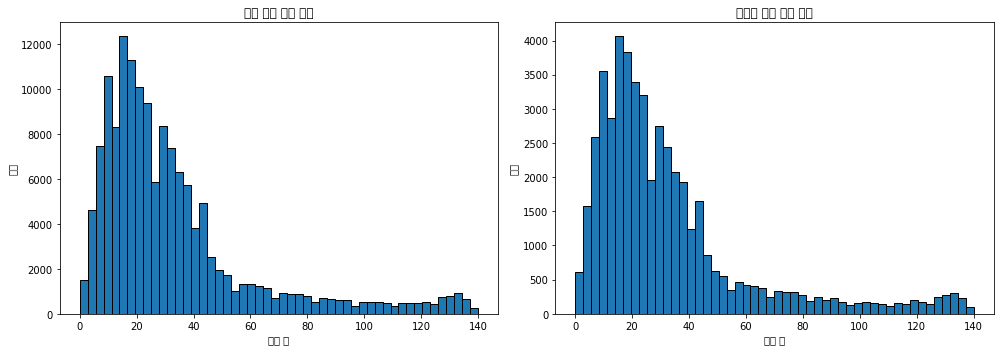

In [36]:
# 시각화
plt.figure(figsize=(14, 5))

# 1. 히스토그램: 대화 길이
plt.subplot(1, 2, 1)
plt.hist(lengths_train, bins=50, edgecolor='black')
plt.title("훈련 대화 길이 분포")
plt.xlabel("문자 수")
plt.ylabel("빈도")

# 2. Countplot: class 분포
plt.subplot(1, 2, 2)
plt.hist(lengths_test, bins=50, edgecolor='black')
plt.title("테스트 대화 길이 분포")
plt.xlabel("문자 수")
plt.ylabel("빈도")

plt.tight_layout()
plt.show()

In [40]:
all_texts = pd.concat([train_data['document'], test_data['document']], ignore_index=True)
len(all_texts)

195339

In [48]:
# clean data 파일로 저장
train_data.to_csv('ratings_train_clean.txt', index=False)  
test_data.to_csv('ratings_test_clean.txt', index=False)  
all_texts.to_csv('ratings_clean.txt', index=False)
input_file = 'ratings_clean.txt'

## 토큰화

**Vocab Size**
1. 말뭉치 크기
- 작은 말뭉치 (~수십만 문장) : 어휘 크기를 너무 크게 하면 과적합(overfitting)되기 쉽고, 희소한 토큰이 많아지므로, 2.000 ~ 8,000 권장 
- 중간규모 말뭉치 (수백만 문장 ) : 16,000 ~ 32,000
- 대규모 말뭉치 (수천만~수억)  : 32,000 ~ 64,000+

2. 한국어 
- 큰 어휘 집합이 더 효율적 

3. 텍스트 분류/감성 분석: 표현력보다는 특징의 일관성이 중요하므로 어휘 크기 작아도 무방

In [96]:
# SentencePiece 학습

VOCAB_SIZE = 6000
seq_max_len =  60

# 모델 이름 prefix
model_prefix = 'nsmc_spm'
model_type = 'bpe'
# --model_type = unigram이 디폴트, bpe 옵션  (일반적을 bep가 감성 분석에 잘 맞음)

# 어휘 수, 문자 커버리지, 토크나이저 타입 등 설정
spm.SentencePieceTrainer.train(
    input=input_file,
    model_prefix=model_prefix,
    vocab_size=VOCAB_SIZE,
    model_type=model_type,             # bpe, unigram, char, word 중 선택 가능
    character_coverage=1.0,            # 한글: 1.0, 일본어: 0.9995, 영어: 1.0
    pad_id=0,                          # [PAD]
    unk_id=1,                          # [UNK]
    bos_id=2,                          # [BOS]
    eos_id=3,                          # [EOS]
    user_defined_symbols=[],           # 필요한 경우 특수토큰 직접 추가
    train_extremely_large_corpus=False  # (말뭉치가 10GB 이상일 때만 True)
)


In [97]:
sp = spm.SentencePieceProcessor()
sp.load("nsmc_spm.model")

text = "이 영화 진짜 재미 있어요!"
tokens = sp.encode(text, out_type=str)
print(tokens) 


['▁이', '▁영화', '▁진짜', '▁재미', '▁있어요', '!']


In [98]:
def sp_tokenize(s, corpus): 

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./nsmc_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, word_index, index_word

In [107]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 어휘 사전 (index <-> word)
sp_tensor, word_to_index, index_to_word = sp_tokenize( sp, all_texts)
print("Vocab Size:", len(index_to_word))

# 문장을 ID 리스트로 변환
x_train = []
for sentence in train_data['document']:
    temp_X = sp.EncodeAsIds(sentence) # 토큰화
    x_train.append(temp_X)

x_test = []
for sentence in test_data['document']:
    temp_X = sp.EncodeAsIds(sentence) # 토큰화
    x_test.append(temp_X)

# 패딩 (길이가 다르므로 텐서화 전 패딩 필요)
x_train_padded = pad_sequences(x_train, maxlen=seq_max_len, padding='post')
x_test_padded = pad_sequences(x_test, maxlen=seq_max_len, padding='post')

# 텐서로 변환 완료
print("x_train shape:", x_train_padded.shape)
print("x_test shape:", x_test_padded.shape)


Vocab Size: 6000
x_train shape: (146182, 60)
x_test shape: (49157, 60)
y_train shape: (146182,)
y_test shape: (49157,)


In [115]:
from sklearn.model_selection import train_test_split


#x_label = train_data['label'].astype('float32').values
#X_train, X_val, y_train, y_val = train_test_split(x_train_padded, x_label, test_size=0.2, random_state=42)

X_train = x_train_padded
y_train = x_test_padded

X_val = train_data['label'].astype('float32').values
y_val = test_data['label'].astype('float32').values

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)

print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)

X_train shape: (146182, 60)
X_val shape: (146182,)
y_train shape: (49157, 60)
y_val shape: (49157,)


## 모델 구성 

In [123]:
word_vector_dim = 128  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.Embedding(VOCAB_SIZE, word_vector_dim, input_length=seq_max_len))
model_lstm.add(tf.keras.layers.Bidirectional( tf.keras.layers.LSTM(word_vector_dim) ))   
model_lstm.add(tf.keras.layers.Dense(8, activation='relu'))
model_lstm.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_lstm.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 60, 128)           768000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               263168    
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 2056      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 1,033,233
Trainable params: 1,033,233
Non-trainable params: 0
_________________________________________________________________


In [126]:
from tensorflow.keras.callbacks import EarlyStopping

model_lstm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 
callbacks = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

history_lstm = model_lstm.fit(
                    X_train, X_val,
                    validation_data=(y_train, y_val),
                    epochs=epochs,
                    batch_size=256,
                    verbose=1, 
                    callbacks = callbacks)

loss, acc = model_lstm.evaluate(y_train, y_val)
print(f" 최종 검증 정확도: {acc:.4f}")
print(f" 최종 검증 loss: {loss:.4f}")

Epoch 1/20
572/572 [==============================] - 12s 18ms/step - loss: 0.4141 - accuracy: 0.8053 - val_loss: 0.3814 - val_accuracy: 0.8306
Epoch 2/20
572/572 [==============================] - 10s 17ms/step - loss: 0.3381 - accuracy: 0.8512 - val_loss: 0.3540 - val_accuracy: 0.8422
Epoch 3/20
572/572 [==============================] - 10s 17ms/step - loss: 0.3084 - accuracy: 0.8656 - val_loss: 0.3390 - val_accuracy: 0.8491
Epoch 4/20
572/572 [==============================] - 10s 17ms/step - loss: 0.2858 - accuracy: 0.8767 - val_loss: 0.3384 - val_accuracy: 0.8490
Epoch 5/20
572/572 [==============================] - 10s 17ms/step - loss: 0.2662 - accuracy: 0.8865 - val_loss: 0.3424 - val_accuracy: 0.8503
Epoch 6/20
572/572 [==============================] - 10s 17ms/step - loss: 0.2448 - accuracy: 0.8978 - val_loss: 0.3556 - val_accuracy: 0.8481
Epoch 7/20
572/572 [==============================] - 10s 17ms/step - loss: 0.2232 - accuracy: 0.9077 - val_loss: 0.3868 - val_accuracy:

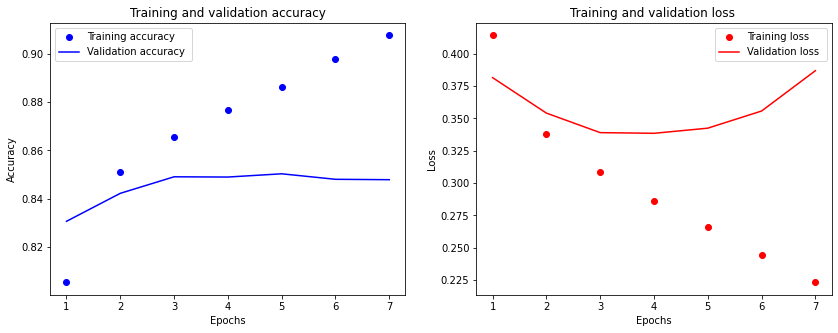

In [127]:
# 시각화

import matplotlib.pyplot as plt

history_dict = history_lstm.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))


plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy ')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'ro', label='Training loss ')
plt.plot(epochs, val_loss, 'r', label='Validation loss ')
plt.title('Training and validation loss ')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()
plt.show()

 **Test 결과 
 - VOCAB = 8000, seq_max_len = 60, type = bpe
     - 최종 검증 정확도: 0.8314
     - 최종 검증 loss: 0.6664
 
 - VOCAB = 6000, seq_max_len = 60, type = bpe
     - 

In [122]:
#문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]